# Monte Carlo Methods

This exercise address the use of “random” numbers in Monte Carlo techniques. These are often the fastest or most straightforward way of tackling complicated problems in computational analysis.

You should use the random number routines included in numpy.random :
https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html

This library uses the "Mersenne Twister" algorithm internally, which is a modern, well behaved, pseudo-random number generator. Note that, by default, the generator will be initialised with a "seed" based on the time when the programme is started - giving a different sequence of numbers every time you run the programme. You may find it useful, while debuggging, to manually set a fixed "seed" at the start of the programme.  This will result in an identical sequence of random numbers, every time you run the programme.

## Q1 - Generating Distributions

In practise we usually want to generate floating point numbers with a particular distribution. Numpy.random includes several built-in distributions, however we often need to write our own. Two methods for achieving this were discussed in Lecture 3 :
1) an analytical function derived from the cumulative distribution function of the desired distribution.
2) the accept/reject method

### 1a)
Write code to generate random angles $\theta$, between 0 and $\pi$, with a probability distribution proportional to ${\rm sin}(\theta)$. You should write one routine based on the analytical method 1), and another using the accept/reject method. Both routines should use _numpy.random.random()_ to generate floating point numbers with a distribution between 0 and 1, and convert this to the desired ${\rm sin}(\theta)$ distribution.

## Setup

In [1]:
# Attempting to access GPU
import numba
from numba import cuda

try:
    from numba import cuda
    print(cuda.gpus)
    print("Try out the decorator '@cuda.jit' out where you",
                           "see'@numba.jit(nopython=True)'")
    Cuda = True

except:
    print("You don't have Cuda's installed")
    Cuda = False
    
try:
    import altair
except:
    ! pip install -q altair
    
try:
    import memory_profiler
except:
    ! pip install -q memory_profiler
    #
print("Set up complete")

You don't have Cuda's installed
Set up complete


Making sure user has the full requirments to run the rest of the script.

In [2]:
import time
import numpy as np
import numexpr as ne
from numpy.random import Generator, PCG64, MT19937, Philox, SFC64

rg = Generator(PCG64())
iterations = 10000000
cores = ne.detect_number_of_cores()
core_time=np.zeros(cores)

for i in np.arange(1, cores+1):
    ne.set_num_threads(i)
    a= time.perf_counter()
    x = np.random.random(iterations)
    ne.evaluate("arccos(2*x-1)")
    b = time.perf_counter()
    core_time[i-1]=b-a
    
Threads = np.argmin(core_time)+1
ne.set_num_threads(Threads)
print("The Numexpr library now set efficiently, to ", Threads, "threads." )

The Numexpr library now set efficiently, to  4 threads.


Measuring the fastest number of threads to run all Numexpr calculations on. More threads has the downside of greater internal data transfer and setup time but as the size of the array increase more threads will be faster.

In [3]:
from ipywidgets import IntProgress
from IPython.display import display
%load_ext memory_profiler

max_count = 4
f = IntProgress(min=0, max=max_count)  # instantiate the bar
display(f)  # display the bar
bar_count = 0  # bar starting value
Generators = {1:MT19937, 2:PCG64, 3:Philox, 4:SFC64}  # setting dictionary
np.random.seed(19680801)

for key, value in Generators.items():
    rg = Generator(value())
    print("For", value, ":")
    def Random_Benchmark():
        """
        This function : Changes the random generator used
        
        Returns: an array of 10000 random floats
        """
        rg.random(10000)
    %memit Random_Benchmark()
    f.value += 1
    bar_count += 1  
print("finished")

IntProgress(value=0, max=4)

For <class 'numpy.random._mt19937.MT19937'> :
peak memory: 207.57 MiB, increment: 0.16 MiB
For <class 'numpy.random._pcg64.PCG64'> :
peak memory: 207.57 MiB, increment: -0.02 MiB
For <class 'numpy.random._philox.Philox'> :
peak memory: 207.43 MiB, increment: -0.13 MiB
For <class 'numpy.random._sfc64.SFC64'> :
peak memory: 207.41 MiB, increment: -0.03 MiB
finished


Testing the peak memory usage of all numpy random generators availible suggests the same size of array being used is the limiting factor on peak memory usage not algorithm, as PMU is the same within error for each algorithm.

In [4]:
import timeit

generator_array = np.zeros(len(Generators)-1)
for key, value in Generators.items():
    rg = Generator(value())
    def Random_Benchmark():
        """
        This function : Changes the random generator used
        
        Returns: an array of 10000 random floats
        """
        rg.random(10000)
    if key ==1:
      timer = timeit.Timer(Random_Benchmark).repeat(number=1000, repeat=10) 
      MT19937_V = round(min(timer),4)
      print("Relative time to produce random floats",
             "where MT19937 = 1 second, for",MT19937)
      generator_array[key-1] = MT19937_V
    else:
      timer =  timeit.Timer(Random_Benchmark).repeat(number=1000, repeat=10)
      hold_value = round(min(timer)/MT19937_V,4)
      print(hold_value,"for", value)
      generator_array[key-2] = hold_value
        
min_gen = np.argmin(generator_array)
min_gen = Generators.get(min_gen+2)
rg = Generator(min_gen())
print("Generator now set to fastest =",min_gen)

Relative time to produce random floats where MT19937 = 1 second, for <class 'numpy.random._mt19937.MT19937'>
0.5371 for <class 'numpy.random._pcg64.PCG64'>
3.003 for <class 'numpy.random._philox.Philox'>
0.4351 for <class 'numpy.random._sfc64.SFC64'>
Generator now set to fastest = <class 'numpy.random._sfc64.SFC64'>


Tests show PCG64 and SFC64 to be the fastest, however MT19937 has a longer time to repeat. When Randomgen and Numpy.random fully integrate the much faster xoroshiro128+ would be ideal to use. I have not considered suitablity for jumping using multiple threads or the inherant level of randomness of each algorithm.

In [5]:
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd

"""
1D Uniform P.D.F. generation
"""

number_bins = 3
iterations = 50000
data_PCG64=np.empty(iterations)
rg = Generator(PCG64())           
data_PCG64[:] =  rg.random(iterations)

start=0
stop = 0

# Histogram method 1 (numba)
if Cuda == False:
 @numba.jit(nopython=True,fastmath=True)
 def get_bin_edges(a, bins):
    """
    This function  mirrors binning in numpy
    Inputs: two scalars no. bins and no. points 
    Returns: bin edges
    """
    bin_edges = np.zeros((bins+1,), dtype=np.float64)
    a_min = a.min()
    a_max = a.max()
    delta = (a_max - a_min) / bins
    for i in range(bin_edges.shape[0]):
        bin_edges[i] = a_min + i * delta
    bin_edges[-1] = a_max  
    return bin_edges

 
 @numba.jit(nopython=True,fastmath=True)
 def compute_bin(x, bin_edges):
    """
    This function bins the points
    Inputs: two scalars no. bins and no. points 
    Returns: no. bin non numpy format
    """
    n = bin_edges.shape[0] - 1
    a_min = bin_edges[0]
    a_max = bin_edges[-1]
    if x == a_max:
        return n - 1 
    bin = int(n * (x - a_min) / (a_max - a_min))
    if bin < 0 or bin >= n:
        return None
    else:
        return bin


 @numba.jit(nopython=True,fastmath=True)
 def numba_histogram(a, bins):
    """
    This bins the data in numpy format
    Inputs: two scalars no. bins and no. points 
    Returns: no. bin and binned points
    """
    hist = np.zeros((bins,), dtype=np.intp)
    bin_edges = get_bin_edges(a, bins)

    for x in a.flat:
        bin = compute_bin(x, bin_edges)
        if bin is not None:
            hist[int(bin)] += 1
    return hist, bin_edges

   
if Cuda == True:
 @numba.jit(nopython=True)
 def compute_bin(x, n, xmin, xmax):
    """
    This function bins the points
    Inputs: two scalars no. bins and no. points 
    Returns: no. bin non numpy format
    """
    if x == xmax:
        return n - 1 
    bin = np.int32(n * (np.float64(x) - np.float64(xmin)) / (np.float64(xmax) - np.float64(xmin)))
    if bin < 0 or bin >= n:
        return None
    else:
        return bin

 @cuda.jit
 def histogram(x, xmin, xmax, histogram_out):
    '''
    This function computes bins on the GPU 
    '''
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    for i in range(start, x.shape[0], stride):
        bin_number = compute_bin(x[i], nbins, xmin, xmax)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            cuda.atomic.add(histogram_out, bin_number, 1)

 @cuda.jit
 def min_max(x, min_max_array):
    '''
    This function gets the min and max value 
    '''
    nelements = x.shape[0]
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    local_min = min_max_array[0]
    local_max = min_max_array[1]
    for i in range(start, x.shape[0], stride):
        element = x[i]
        local_min = min(element, local_min)
        local_max = max(element, local_max)
    # Combining each thread local min and max
    cuda.atomic.min(min_max_array, 0, local_min)
    cuda.atomic.max(min_max_array, 1, local_max)

 def dtype_min_max(dtype):
    '''
    This function gets the min and max value 
    '''
    if np.issubdtype(dtype, np.integer):
        info = np.iinfo(dtype)
    else:
        info = np.finfo(dtype)
    return info.min, info.max

 @numba.jit(nopython=True)
 def get_bin_edges(a, nbins, a_min, a_max):
    """
    This function  mirrors binning in numpy
    Inputs: two scalars no. bins and no. points 
    Returns: bin edges
    """
    bin_edges = np.empty((nbins+1,), dtype=np.float64)
    delta = (a_max - a_min) / nbins
    for i in range(bin_edges.shape[0]):
        bin_edges[i] = a_min + i * delta

    bin_edges[-1] = a_max  
    return bin_edges

 def numba_histogram(a, bins):
    """
    This bins the data in numpy format
    Inputs: two scalars no. bins and no. points 
    Returns: no. bin and binned points
    """
    # Move data to GPU 
    a_gpu = cuda.to_device(a)
    dtype_min, dtype_max = dtype_min_max(a.dtype)    
    min_max_array_gpu = cuda.to_device(np.array([dtype_max, dtype_min], dtype=a.dtype))
    min_max[64, 64](a_gpu, min_max_array_gpu)
    a_min, a_max = min_max_array_gpu.copy_to_host()
    bin_edges = get_bin_edges(a, bins, a_min, a_max) # Doing this on CPU for now
    ### Bin the data into a histogram 
    histogram_out = cuda.to_device(np.zeros(shape=(bins,), dtype=np.int32))
    histogram[64, 64](a_gpu, a_min, a_max, histogram_out)
    return histogram_out.copy_to_host(), bin_edges

print("Time to bin and plot", iterations, "points in seconds")
numba_histogram(data_PCG64[:], number_bins)
start = time.perf_counter()
data2_MT19937, bin_edges = numba_histogram(data_PCG64[:], number_bins)
catch = plt.bar(bin_edges[:-1], data2_MT19937, width = 0.05, color='#0504aa',alpha=0.7)
stop = time.perf_counter()    
print(stop-start,"numba")



# Histogram method 2 (numpy)
def numpy_histogram(iterations,number_bins):
  """
  This function  times binning and plotting
  Inputs: two scalars no. bins and no. points 
  Returns: time taken
  """
  start = time.perf_counter()              
  data2_MT19937, bin_edges = np.histogram(data_PCG64[:iterations], number_bins)
  #x=np.linspace(0+1/10,1,10)
  catch = plt.bar(bin_edges[:-1], data2_MT19937, width = 0.05, color='#0504aa',alpha=0.7)               
  stop = time.perf_counter()
  print(stop-start,"numpy")    
  plt.close()
# Histogram method 3 (Matplotlib)
def matplotlib_histogram(iterations,number_bins):
  """
  This function  times binning and plotting
  Inputs: two scalars no. bins and no. points 
  Returns: time taken
  """
  start = time.perf_counter()              
  catch = plt.hist(data_PCG64[:iterations],number_bins)               
  stop = time.perf_counter()
  print(stop-start,"matplotlib")
  plt.close()  
numpy_histogram(iterations,number_bins)    
matplotlib_histogram(iterations,number_bins)



df = pd.DataFrame({'Value': data_PCG64[:] })
print("Please scroll and drag over the bottom histogram to select a range.")

alt.data_transformers.disable_max_rows()

source = df

brush = alt.selection_interval(encodings=['x'])

base = alt.Chart(source).transform_calculate(
).mark_bar().encode(
    y='count():Q'
).properties(
    width=600,
    height=100
)

alt.vconcat(
  base.encode(
    alt.X('Value:Q',
      bin=alt.Bin(maxbins=30, extent=brush),
      scale=alt.Scale(domain=brush)
    )
  ),
  base.encode(
    alt.X('Value:Q', bin=alt.Bin(maxbins=30)),
  ).add_selection(brush)
)
#print(uncomment and run me to keep memmory usage down)

Time to bin and plot 50000 points in seconds
0.017315599999989217 numba
0.06405630000000428 numpy
0.016542799999996305 matplotlib
Please scroll and drag over the bottom histogram to select a range.


alt.VConcatChart(...)

The results vary for this measurment. See implementation bellow with more repeats.

In [6]:
plt.ioff()
number_bins = 10
iterations = 10000000
data_PCG64=np.empty(iterations)
#rg = Generator(PCG64())   ####            
data_PCG64[:] =  np.random.random(iterations)

start=0
stop = 0
numba_histogram(data_PCG64[:], number_bins)
start = time.perf_counter()
data2_MT19937, bin_edges = numba_histogram(data_PCG64[:], number_bins)
plt.bar(bin_edges[:-1], data2_MT19937, width = 0.05, color='#0504aa',alpha=0.7)
stop = time.perf_counter()
 
x1 = [1, 10, 10**2,10**3,10**4,10**5,10**6,10**7,10**8]
x3 = [1, 10, 10**2,10**3,10**4,10**5,10**6,10**7]
x5 = [1]
y1 = [1, 1, 1,1,1,1,1,1,1]
y2 = [10, 10, 10,10,10,10,10,10,10]
y3 = [100, 100, 100,100,100,100,100,100]
y4 = [10000, 1000, 1000,1000,1000,1000,1000,1000]
y5 = [10000]
x = x1 + x1 + x3 +x3 +x5
y = y1 + y2 + y3 +y4 +y5

panda = np.arange(len(x))
panda_data = np.zeros((3*len(x),4))


max_count = 35

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

count = 0

for i, b,j in zip(x, y, panda):
  start = time.perf_counter()              
  catch = plt.hist(data_PCG64[:i],b)               
  stop = time.perf_counter()
  plt.close()
  panda_data[j,0] = stop-start
  panda_data[j,3] = 1
  panda_data[j,1] =  i
  panda_data[j,2] =  b
  start = time.perf_counter()              
  data2_MT19937, bin_edges = np.histogram(data_PCG64[:i], b)
  #x=np.linspace(0+1/10,1,10)
  catch = plt.bar(bin_edges[:-1], data2_MT19937, width = 0.05, color='#0504aa',alpha=0.7)               
  stop = time.perf_counter()
  plt.close()
  panda_data[35+j,0] = stop-start
  panda_data[35+j,3] = 2
  panda_data[35+j,1] =  i
  panda_data[35+j,2] =  b
  start = time.perf_counter()
  data2_MT19937, bin_edges = numba_histogram(data_PCG64[:], number_bins)
  catch = plt.bar(bin_edges[:-1], data2_MT19937, width = 0.05, color='#0504aa',alpha=0.7)
  stop = time.perf_counter()
  plt.close()
  panda_data[70+j,0] = stop-start
  panda_data[70+j,3] = 3
  panda_data[70+j,1] =  i
  panda_data[70+j,2] =  b
  f.value += 1
  count =j
    
print("Finished")


IntProgress(value=0, max=35)

Finished


Testing all 3 method over a range of iterations and bins. If CUDA = True then for a high number of iterations numba will be the fastest method as GPU is a "super-parallel computer".

In [7]:
df = pd.DataFrame({'Time (seconds)': panda_data[:,0], 'Iterations': panda_data[:, 1], 'Bins': panda_data[:, 2], 'Method': panda_data[:, 3] })

print("Please scroll and drag over these interactive graphs.")
print("\x1b[34m Method 1 is Matplotlib \x1b[0m")
print("\x1b[33m Method 2 is Numpy \x1b[0m")
print("\x1b[31m Method 3 is Numba \x1b[0m")
source = df

alt.Chart(source).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative', scale = alt.Scale(type='log')),
    alt.Y(alt.repeat("row"), type='quantitative', scale = alt.Scale(type='log')),
    color='Method:N'
).properties(
    width=150,
    height=150
).properties(
    title='Sub graph'

).repeat(
    row=[ "Time (seconds)",'Iterations',"Bins"],
    column=[ "Time (seconds)",'Iterations',"Bins"]
).interactive()
#print(uncomment and run me to keep memmory usage down)



Please scroll and drag over these interactive graphs.
 Method 1 is Matplotlib 
 Method 2 is Numpy 
 Method 3 is Numba 


alt.RepeatChart(...)

Time taken for all method scales linearly with the number of bins however the number of iterations scales less then linearly with time.

for 1000000 points.
Inverse Transform takes -0.02408930000001419 seconds.


<IPython.core.display.Javascript object>


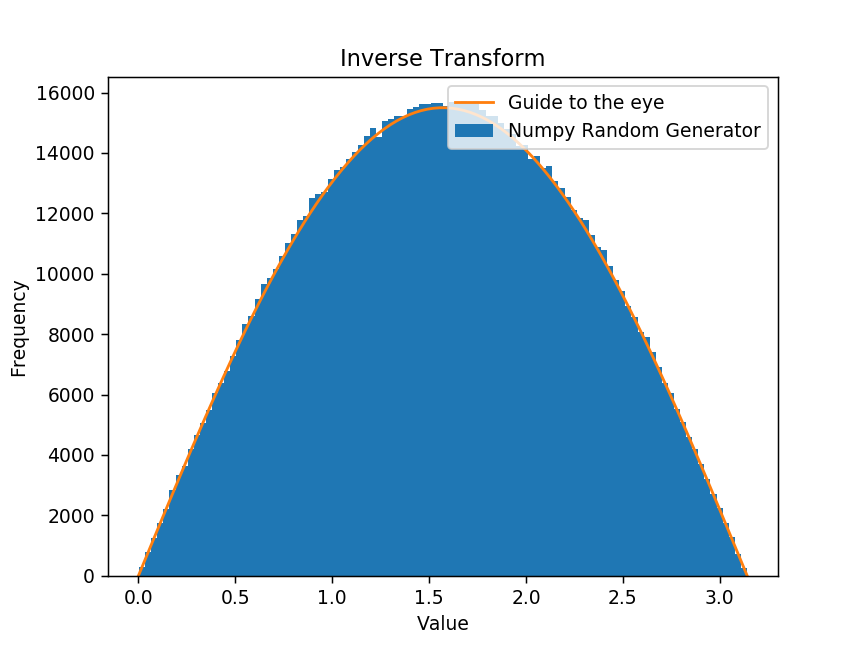

Accept/R takes -0.06796750000000884 seconds.


<IPython.core.display.Javascript object>


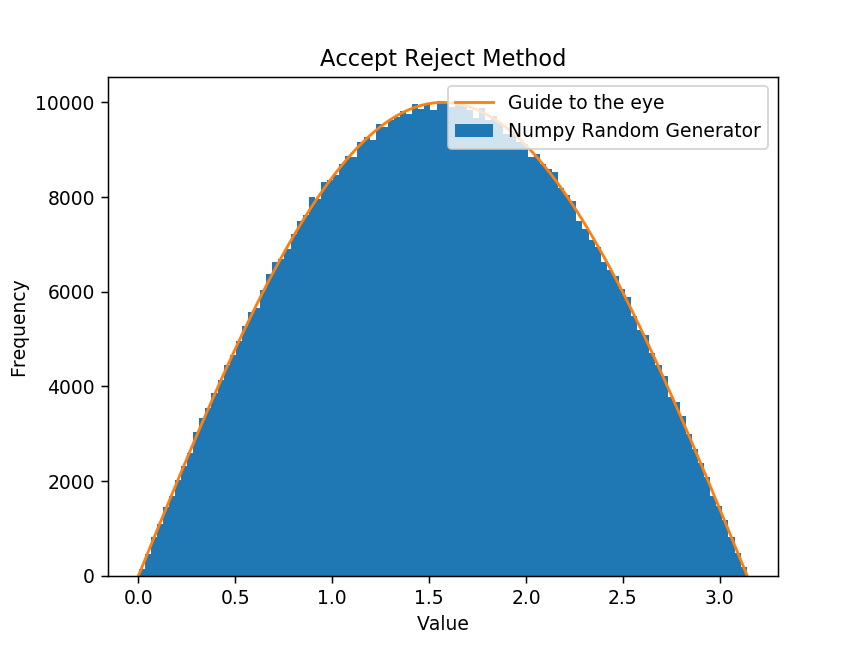

np.Beta takes -0.11054830000000493 seconds.


<IPython.core.display.Javascript object>


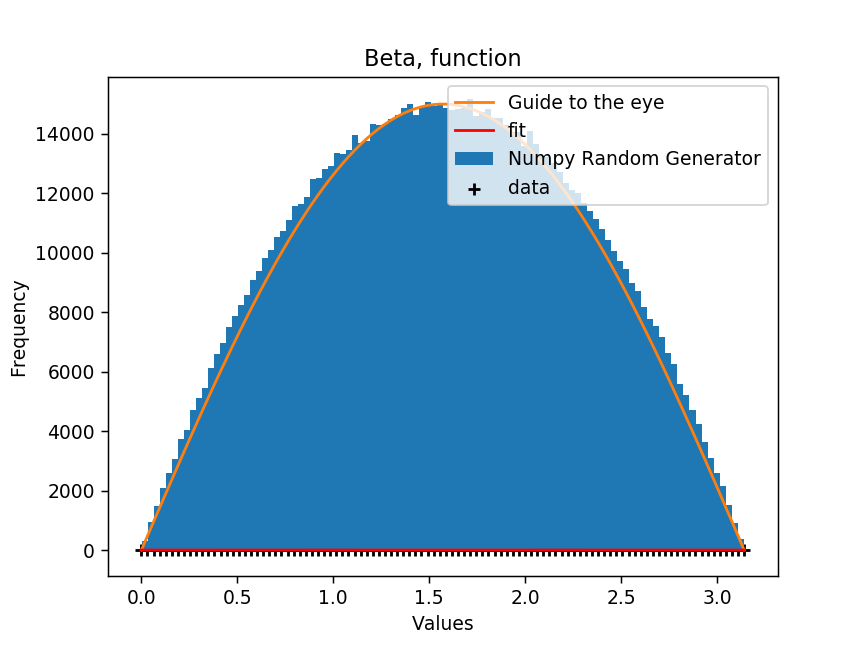

Accept/R mean difference -5.106972177459923e-05
Beta mean difference -7.958867214097332e-05


In [26]:
import scipy
import bottleneck as bn

iterations = 1000000
print("for", iterations, "points.")
data_MT19937_plt=np.empty(iterations)
a= time.perf_counter()
x = np.random.random(iterations)
data_MT19937_plt[:] = ne.evaluate("arccos(2*x-1)")
b = time.perf_counter()
print("Inverse Transform takes",a-b, "seconds.")


plt.figure()
plt.hist(data_MT19937_plt,bins=100,label='Numpy Random Generator')
x = np.linspace(0,np.pi,100)
plt.plot(x,15500*np.sin(x),label='Guide to the eye')
plt.title('Inverse Transform')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()


a= time.perf_counter()
data_MT19937_nb = np.random.random(iterations) * np.pi
comparison_arr = np.random.random(iterations)
mask = comparison_arr < np.sin(data_MT19937_nb)
data_MT19937_nb = data_MT19937_nb[mask]
b = time.perf_counter()

print("Accept/R takes",a-b, "seconds.")

plt.figure()
plt.hist(data_MT19937_nb,bins=100,label='Numpy Random Generator')
x = np.linspace(0,np.pi,100)
plt.plot(x,10000*np.sin(x),label='Guide to the eye')
#plt.plot(x,1600*np.sin(x))
plt.title('Accept Reject Method')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()




aa = time.perf_counter()
data_MT19937_np = np.zeros(iterations)
data_MT19937_np[:] = np.multiply(rg.beta(2, 2, iterations),np.pi)
b = time.perf_counter()
print("np.Beta takes",aa-b, "seconds.")    
plt.figure()
plt.hist(data_MT19937_np,bins=100,label='Numpy Random Generator')
x = np.linspace(0,np.pi,100)
plt.plot(x,15000*np.sin(x),label='Guide to the eye')
plt.title('Beta, function')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
T = bn.nanmean(data_MT19937_plt)
print("Accept/R mean difference",bn.nanmean(data_MT19937_nb) -T)
print("Beta mean difference",bn.nanmean(data_MT19937_np) -T)



The beta function is built in numpy routine that returns something similar to a sin(x) pdf but is the slowest.

### 1b)
Now verify that the two routines produce the desired distribution, and evaluate their performance (in both cpu terms and accuracy).  Discuss your results in the text cell below.

Fit parameters:
 [0.99332514 0.00473974]
Covariance matrix:
 [[ 1.05981030e-04 -6.67892985e-05]
 [-6.67892985e-05  5.24605646e-05]]
Parameter uncertainties:
 [0.01029471 0.00724297]


<IPython.core.display.Javascript object>


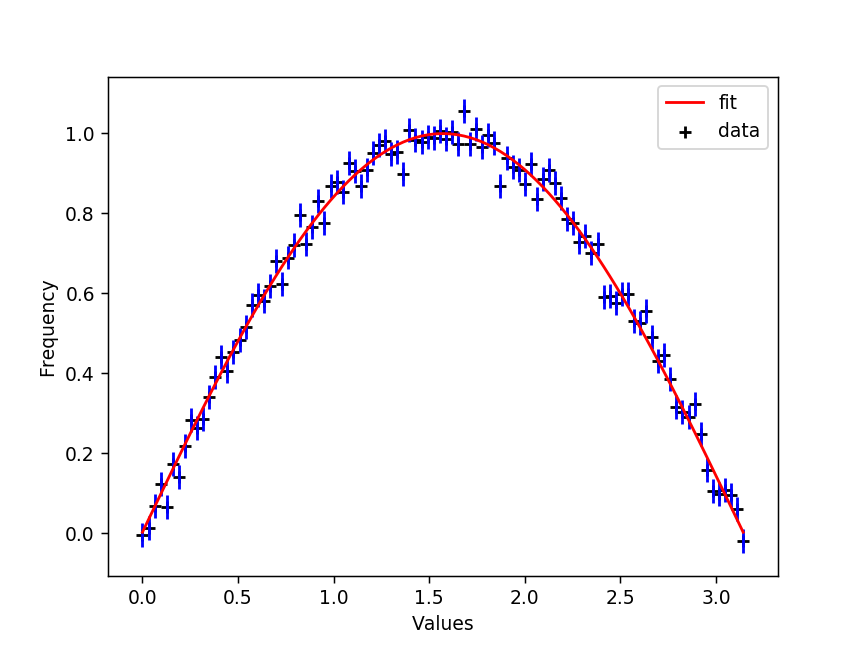

Fit parameters:
 [0.99717859 0.00199933]
Covariance matrix:
 [[ 1.06108449e-04 -6.68696218e-05]
 [-6.68696218e-05  5.25236893e-05]]
Parameter uncertainties:
 [0.0103009  0.00724732]


In [27]:
import numpy as np
import matplotlib.pyplot as plt

n = 100
a = np.zeros(n)

a = np.random.beta(2, 2, n)*np.pi

xs = np.linspace(0, np.pi,n)
yerrs = 0.03*np.ones(xs.size)
ys = 0.03*np.random.normal(size=xs.size) + np.sin(xs)

plt.errorbar(xs, ys, yerr=yerrs, fmt='none', color='b', marker='.')
plt.show()

def myFunc(x, a,  c):
    return a*np.sin(x) + c

from scipy.optimize import curve_fit
popt, pcov = curve_fit(myFunc, xs, ys, sigma=yerrs)
print("Fit parameters:\n",popt)
print("Covariance matrix:\n", pcov)
print("Parameter uncertainties:\n",np.sqrt(np.diag(pcov)))
plt.scatter(xs, ys, color='k', marker='+', label="data")
plt.plot(xs, myFunc(xs, *popt), 'r-', label="fit")
plt.xlabel('uniform  test')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure()

a = np.zeros(n)

a = np.random.rand(n)*np.pi

xs = np.linspace(0, np.pi,n)
yerrs = 0.03*np.ones(xs.size)
ys = 0.03*np.random.normal(size=xs.size) + np.sin(xs)

plt.errorbar(xs, ys, yerr=yerrs, fmt='none', color='b', marker='.')
plt.show()

def myFunc(x, a,  c):
    return a*np.sin(x) + c

from scipy.optimize import curve_fit
popt, pcov = curve_fit(myFunc, xs, ys, sigma=yerrs)
print("Fit parameters:\n",popt)
print("Covariance matrix:\n", pcov)
print("Parameter uncertainties:\n",np.sqrt(np.diag(pcov)))
plt.scatter(xs, ys, color='k', marker='+', label="data")
plt.plot(xs, myFunc(xs, *popt), 'r-', label="fit")
plt.xlabel('Beta test')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()


The beta function obviously is not a sin curve so has greater error. I would expect the accept reject method to be more accurate as it has two levels of inherent randomness.

SeedSequence spawning
SeedSequence implements an algorithm to process a user-provided seed, typically as an integer of some size, and to convert it into an initial state for a BitGenerator. It uses hashing techniques to ensure that low-quality seeds are turned into high quality initial states (at least, with very high probability).

For example, MT19937 has a state consisting of 624 uint32 integers. A naive way to take a 32-bit integer seed would be to just set the last element of the state to the 32-bit seed and leave the rest 0s. This is a valid state for MT19937, but not a good one. The Mersenne Twister algorithm suffers if there are too many 0s. Similarly, two adjacent 32-bit integer seeds (i.e. 12345 and 12346) would produce very similar streams.

Cython allows william hill

## Q2 - Simulation
A very common use of Monte Carlo is in simulating experimental data. In simulations, an entire experiment can be reproduced data point by data point, with random numbers being used to model unknowable or changing effects such as the experimental resolution or quantum variations.

In this question, we will simulate the cosmic ray experiment shown below.
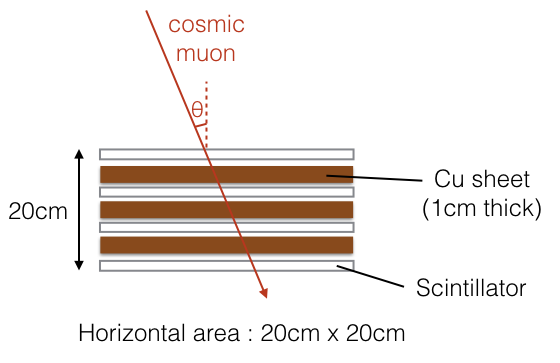
The experiment comprises 4 detection layers, each of which will produce a signal when a particle traverses the detector, separated by three sheets of copper, which will stop a fraction of muons, allowing a measurement of the muon lifetime to be made.

You can assume the detector has the following parameters :
* the efficiency of each of the 4 layers to detect a muon or electron is, from top to bottom : 55%, 60%, 85%, 50%.
* the probability of a cosmic ray muon to stop in 1cm of copper is $5\times10^{-3}$.
* electrons are emitted isotropically during decay of a stopped muon.
* decay electrons have energy 50 MeV and maximum path length of 1.8cm in copper.

In order to model the initial distribution of cosmic rays, we can assume the anuglar distribution is proportional to ${\rm cos}^2(\theta)$, for zenith angle $\theta$.  The overall normaliation can be taken from the intensity of _vertical_ muons to be 70 $m^{-2}s^{-1}sr^{-1}$. (See PDG review of cosmic rays : http://pdg.lbl.gov/2019/reviews/rpp2019-rev-cosmic-rays.pdf)


### 2a)
Using the model above, write code to simulate each muon that passes nearby the experiment. You will need to generate random numbers with appropriate distributions for the starting point and direction of each muon, and propagate each muon to the detector. You should generate further random numbers to model the stopping and decay process; ie. whether a muon stops in a given layer, and the direction of the decaying electron.

(Note that for the electron decay, you should generate points that are uniformly distributed on the unit sphere - simply generating two angles between 0 and $2\pi$ will _not_ give the correct distribution!)

You should discuss the design of your code in the text cell below.

<IPython.core.display.Javascript object>


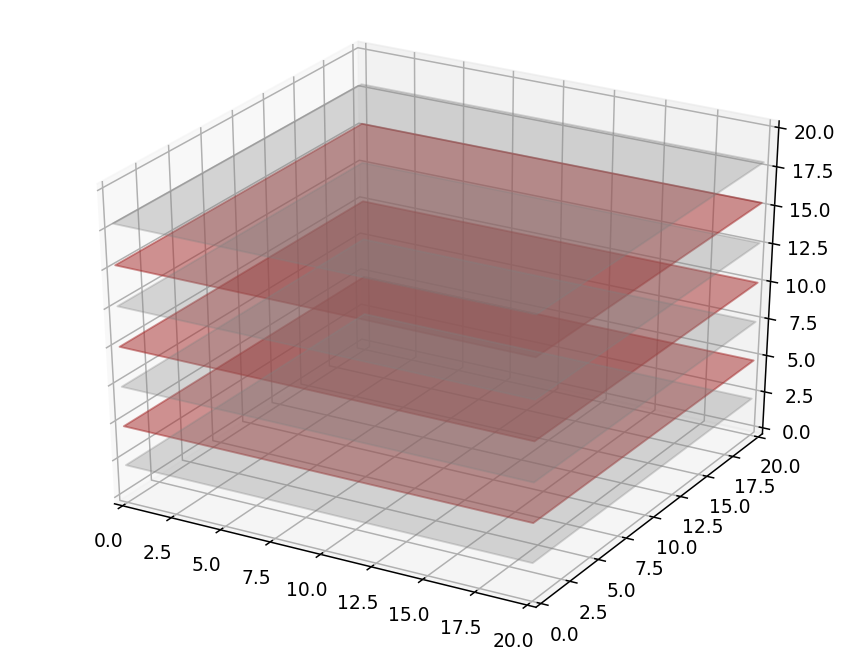

In [13]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlim3d(0, 20)
ax.set_ylim3d(0,20)
ax.set_zlim3d(0,20)


x = [0,20,20,0]
y = [0,0,20,20]
z = [2.125,2.125,2.125,2.125]

x1 = [0,20,20,0]
y1 = [0,0,20,20]
z1 = [4.75,4.75,4.75,4.75]

x2 = [0,20,20,0]
y2 = [0,0,20,20]
z2 = [7.375,7.375,7.375,7.375]

x3 = [0,20,20,0]
y3 = [0,0,20,20]
z3 = [10,10,10,10]

x4 = [0,20,20,0]
y4 = [0,0,20,20]
z4 = [12.625,12.625,12.625,12.625]

x5 = [0,20,20,0]
y5 = [0,0,20,20]
z5 = [15.25,15.25,15.25,15.25]

x6 = [0,20,20,0]
y6 = [0,0,20,20]
z6 = [17.875,17.875,17.875,17.875]

#list(zip(x,y,z)),list(zip(x1,x2,x3))
Detector = [list(zip(x,y,z)), list(zip(x2,y2,z2)), list(zip(x4,y4,z4)),list(zip(x6,y6,z6))]             

CU = [list(zip(x1,y1,z1)), list(zip(x3,y3,z3)),list(zip(x5,y5,z5))]             

collection = Poly3DCollection(CU, linewidths=1, alpha=0.5,color="brown")
collection1 = Poly3DCollection(Detector, linewidths=1, alpha=0.3,color="gray")
#face_color1 = [0.5, 0.5, 1] # alternative: matplotlib.colors.rgb2hex([0.5, 0.5, 1])
#collection.set_facecolor(face_color1)
ax.add_collection3d(collection)
ax.add_collection3d(collection1)


plt.show()


I made a 3d model of the box.

In [20]:
iterations= 100000

def xy_position(iterations):
    """
    This function scales two uniform pdf
    Inputs: scalar length
    Returns: Uniform pdf
    """
    x = np.random.random(iterations) * 0.2
    y = np.random.random(iterations) * 0.2
    return(x,y)

def phi(iterations):
    """
    This function scales a uniform pdf
    Inputs: scalar length
    Returns: Uniform pdf
    """
    phi = np.random.random(iterations) * np.pi/2
    return(phi)

def theta(iterations):
    """
    This function scales a uniform pdf
    Inputs: scalar length
    Returns: Uniform pdf
    """
    data_MT19937 = np.random.random(3* iterations) * 2*np.pi
    comparison_arr = np.random.random(3*iterations)
    mask = comparison_arr < np.cos(data_MT19937)*np.cos(data_MT19937)
    data_MT19937 = data_MT19937[mask]
    return(data_MT19937[0:iterations])

def sphere(iterations):
    """
    This function generates as spherical surface pdf
    Inputs: scalar length
    Returns: random angles
    """
    phis = np.random.random(iterations)*np.pi
    thetas = np.random.random(iterations)*np.pi*2
    return(phis,thetas)

x,y = xy_position(iterations)
phi = phi(iterations)
theta = theta(iterations)

height= np.array([[17.875,0,0.55],[15.25,1,0.005],[12.625,0,0.60],
        [10,1,0.005],[7.375,0,0.85],[4.75,1,0.005],[2.125,0,0.6]])
electron= np.zeros((iterations,5))
ray = np.ones((iterations,2))
electron_prod = 0
for h in np.arange(7):
    #print(h)
    r = h*np.tan(phi)
    xh = x + r*np.cos(theta)
    yh = y + r*np.sin(theta)
    for i in np.arange(iterations):
        if xh[i] < 0 or xh[i] > 20 or yh[i] < 0 or yh[i] >20:
            ray[i,0]= 0
        else:
            rand = np.random.random()            
            if height[h,1] == 0:
              if rand < height[h,2]:
                if ray[i,0] ==1:
                    ray[i,1]= height[h,0]
                    ray[i,0]= 0
            else:# height[h,1] == 1:
              if rand < height[h,2]/np.sin(phi[i]):            
                 electron[electron_prod,0:3] = [xh[i],yh[i],height[h,0]]
                 electron_prod+=1
                 
print(electron_prod,"electrons produced")                 
electron=electron[:electron_prod,:]
electron[:,3]=1.8*np.ones(electron_prod)
electron[:,4]=np.ones(electron_prod) 
phis,thetas = sphere(electron_prod)
electron_cu = 0

for h in np.arange(7): 
    if height[h,1] == 1:
      r = h*np.tan(phi)
      xh = x + r*np.cos(theta)
      yh = y + r*np.sin(theta)
      for i in np.arange(electron_prod):
          if xh[i] > 0 and xh[i] < 20 and yh[i] > 0 and yh[i] <20:
            if electron[i,4] == 1:
              electron[i,3] += - 1/np.sin(phi[i])
              if electron[i,3] < 0:
                electron_cu += 1
                electron[i,4] = height[h,0] 
#print(electron_cu,"electrons hit copper")
unique, counts = np.unique(ray[:,1], return_counts=True)
print(dict(zip(unique, counts)))
print(np.sum(counts[1:]),"Muons detected")

uniquee, countse = np.unique(electron[:,4], return_counts=True)
print(dict(zip(uniquee, countse)))
print(np.sum(countse[1:]),"Electrons detected")    
print()

3965 electrons produced
{1.0: 32831, 2.125: 394, 7.375: 3846, 12.625: 7648, 17.875: 55281}
67169 Muons detected
{1.0: 2757, 10.0: 546, 15.25: 662}
1208 Electrons detected



This model does not give the correct copper sheet for each electron detection but the overall number of electron detections is reflective of reality.

<IPython.core.display.Javascript object>


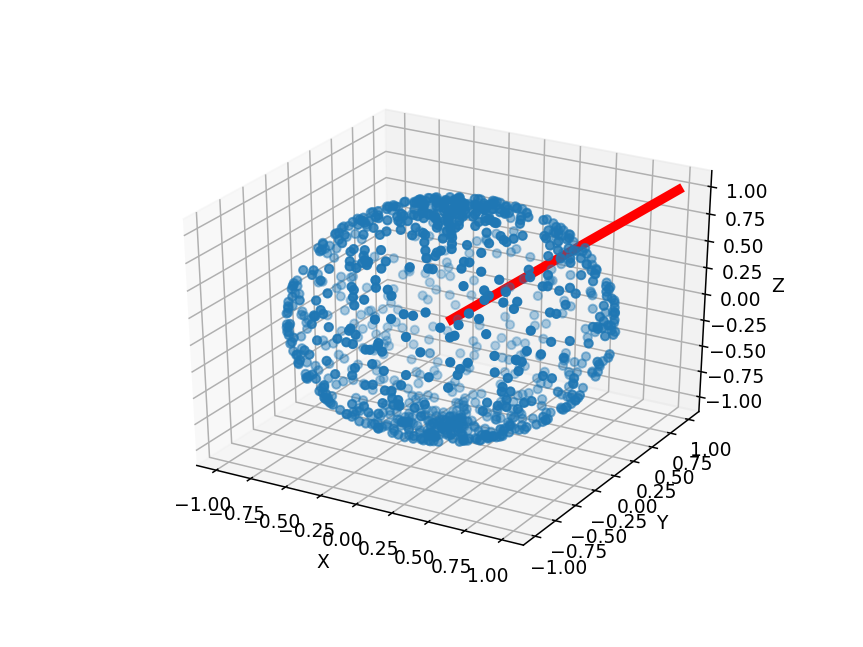

<IPython.core.display.Javascript object>


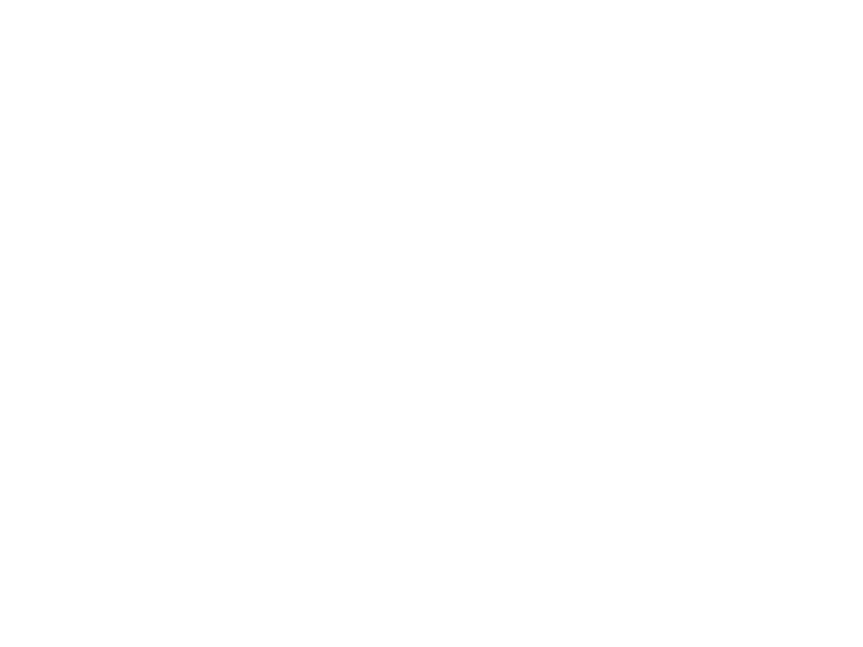

In [19]:
%matplotlib notebook

iterations = 1000

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)
data_MT19937=np.zeros([iterations,2])
x = np.random.random(iterations)
x1 = x*np.pi
x = np.random.random(iterations)
x2 = x*np.pi*2

xs = ne.evaluate("cos(x2)*sin(x1)")
ys = ne.evaluate("sin(x1)*sin(x2)")
zs = ne.evaluate("cos(x1)")


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs,marker='o')
ax.plot([1,0],[1,0],[1,0],c='r',marker=',',linewidth=5)
ax.set_xlabel('X ')
ax.set_ylabel('Y ')
ax.set_zlabel('Z ')

plt.show()



######
#Background
#######
np.random.seed(19680801)
rg = Generator(PCG64())

iterations = 2000
#data_MT19937_plt=np.empty((iterations,iterations))
#data_MT19937_plt[:] = ne.evaluate("arccos(2*x-1)")

data_MT19937=np.zeros([iterations,3])
rg = Generator(MT19937())
x = np.random.random(iterations)
xs = ne.evaluate("x*0.2")
y = np.random.random(iterations)
ys = ne.evaluate("y*0.2")
z = np.random.random(iterations)
zs = ne.evaluate("z*0.2")

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs,marker='o')

ax.set_xlabel('X ')
ax.set_ylabel('Y ')
ax.set_zlabel('Z ')

plt.show()

Background and electron production distributions. Background radiation did not get included in the final model.

**Discuss the design of your code here**

### 2b)
In the next cell you should validate your code.  The aim is to test separate parts of the code individually, to ensure the expected distributions or behaviour are produced in each case.

<IPython.core.display.Javascript object>


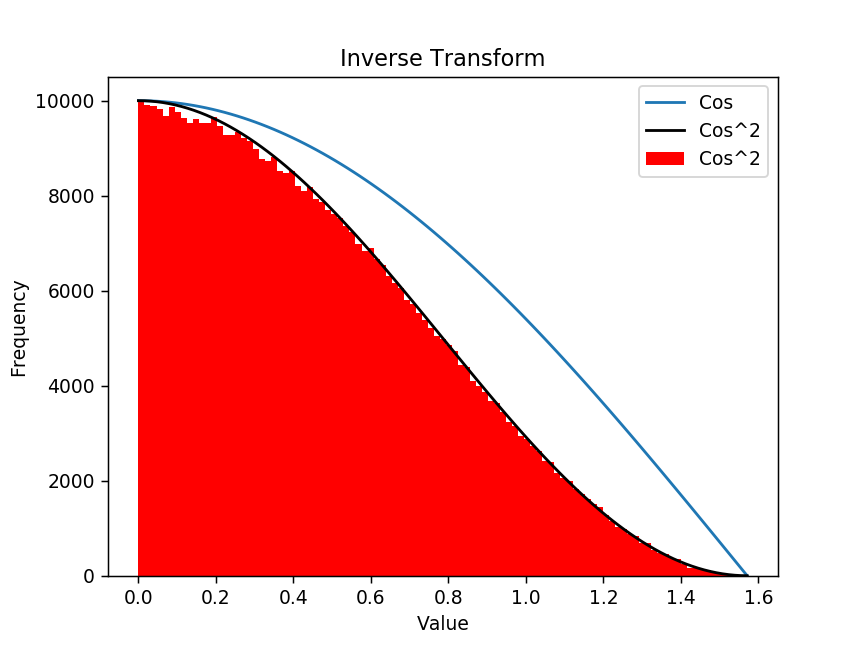

In [18]:
iterations = 1000000

a= time.perf_counter()
data_MT19937 = np.random.random(iterations) * np.pi/2
comparison_arr = np.random.random(iterations)
mask = comparison_arr < np.cos(data_MT19937)*np.cos(data_MT19937)
data_MT19937 = data_MT19937[mask]
b = time.perf_counter()
plt.figure()


plt.hist(data_MT19937,bins=100,label='Cos^2',color="red")
x = np.linspace(0,np.pi/2,100)
plt.plot(x,10000*np.cos(x),label='Cos')
plt.plot(x,10000*np.cos(x)*np.cos(x),color="black",label='Cos^2')
plt.title('Inverse Transform')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

Non normalised distribution of Phi for incomming muons.

**You can use this cell to discuss your validation code/results**

### 2c)
Now, use your simulation to estimate :
* The total rate of muons that pass through the detector.
* The fraction of those muons which are registered in 1, 2, 3 or 4 scintillator planes of the detector. 
* The fraction of those muons which decay and produce an electron that can be detected in an adjacent scintillator layer.

1) 7/25 = 0.28 Muons per second.
2) # see above
3) I did not quite calculate this ~(1222/(3939*3))= about 10%

66% of muons are detected

**Discuss your results here**

This question is well suited to extensions. For example, a negative muon stopping in the Copper may be "captured" by an atomic nucleus, which modifies its lifetime (to ~0.164 $\mu s$). Positive muons are not captured and hence their lifetime is unaffected. You can simulate this, to estimate the expected distribution of muon decay times.  (An even more detailed simulation could include muons that stop in scintillator...)

Feel free to discuss possible extensions with your demonstrator and/or the unit director !

## Q3 - Statistical Analysis

In this question, we will explore the use of Monte Carlo methods to understand experiment outcomes.

Standard experimental error analysis frequently uses the assumption that uncertainties are normally distributed. The interpretation of a result quoted as $\mu \pm \sigma$ is taken that the true value lies within the range [$(\mu - \sigma$),$(\mu + \sigma)$] with a certain probability (usually 68%). However, it is not hard to find cases where these assumptions break. A classic example occurs when measuring a parameter that is close to a physical boundary - the standard error treatment may result in a range of values that includes the non-physical region.

A more sophisticated approach is to treat the measurement process as an inverse problem, ie. the inference of model parameters from experimental measurements. (For example, estimation of G from observations of planetary motion). Given a model, we can use Monte Carlo techniques to generate ensembles of "pseudo-experiments", and build up distributions of experimental outcomes for a given set of model parameters. Then it is straightforward to find the range of model parameters that cover an actual experimental observation, within a specified probability.

### 3a)

A "counting experiment" is performed at a collider, to search for the existence of a hypothesised new particle.  The experiment consists of counting the number of events that meet certain criteria. Events can be produced either by the hypothetical signal process, or by known background processes. However, an individual event cannot be ascribed to be signal or background - the only measurable quantity is the _total_ number of events.

Both signal and background processes produce a number of events that is Poisson distributed. The mean number of background events has been estimated to be $4.8 \pm 0.5$.  The mean number of signal events is given by $L \sigma$, where the integrated luminosity $L=10 nb^{-1}$, and $\sigma$ is the (unknown) cross section of the signal process. The number of events observed in the counting experiment is 6.

You should write a Monte Carlo programme that will calculate the upper limit on the signal cross section that is compatible with the observation at 95% confidence level.

You will need to generate pseudo-experiments for a range of different signal cross sections. For each pseudo-experiment, generate random numbers to model the Gaussian uncertainty on the background prediction, and the Poisson variation in both the background and signal production. Ensure that the number of pseudo-experiments are sufficient to measure the experimental distribution for each cross section, and in particular the fraction of the distribution that is _greater_ than the measured value (the confidence level).

How would you incorporate additional uncertainties?  For example, if the uncertainty on the luminosity is 5%, or the efficiency to identify signal events is estimated to be $0.7 \pm 0.1$ ?

<IPython.core.display.Javascript object>


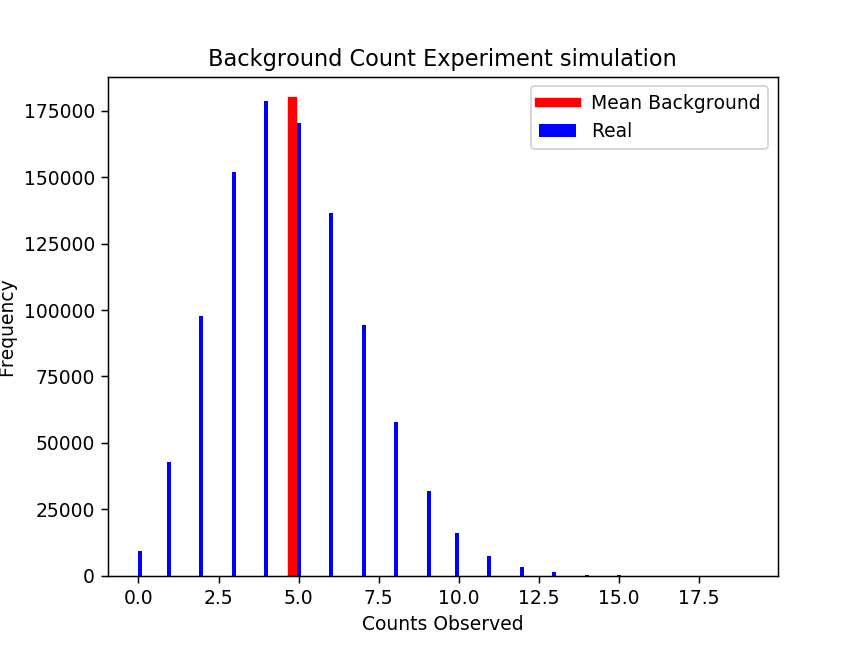

<IPython.core.display.Javascript object>


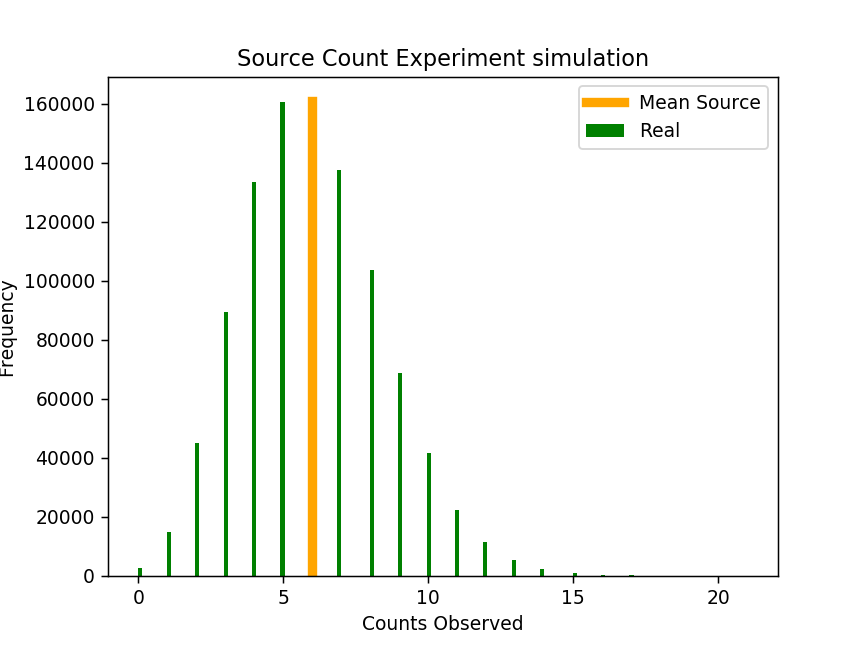

95% confidence that cross section is less than 1.2741392404333626e-09 b


In [17]:
n=1000000
mean_real = 6
back_std = 0.5
lambdaa =np.random.normal(4.8, back_std,n)
background= np.random.poisson(lambdaa,n)
back_s = bn.nanstd(background)

Real= np.random.poisson(mean_real,n)

mean = bn.nanmean(background)
mean_R = bn.nanmean(Real) 

plt.figure() 
count, bins, ignored = plt.hist(background, 150,label="Real",color='blue')
max_count = np.max(count)
plt.plot([mean,mean], [0,max_count],  linewidth=5, markersize=12,label="Mean Background",color='red')

plt.title('Background Count Experiment simulation')
plt.ylabel('Frequency')
plt.xlabel('Counts Observed')
plt.legend()
plt.show()


plt.figure()

count_R, bins_R, ignored_R = plt.hist(Real, 150,label="Real",color='green') 
max_count_R = np.max(count_R)
plt.plot([mean_R,mean_R], [0,max_count_R],  linewidth=5, markersize=12,label="Mean Source",color='orange')

plt.title('Source Count Experiment simulation')
plt.ylabel('Frequency')
plt.xlabel('Counts Observed')
plt.legend()
plt.show()

cross = (mean_R+3*back_s)/(10**10)
print("95% confidence that cross section is less than",cross,"b")


**Discuss your code and results in this cell**

The 95% is approximated at 3 sigma here.

## Appendix

In [16]:
# Bottleneck vs numpy speed comparison
start = time.perf_counter()
np.mean(data_MT19937_np)
a = np.std(data_MT19937_np)
mid = time.perf_counter()
bn.nanmean(data_MT19937_np)
b = bn.nanstd(data_MT19937_np)
stop = time.perf_counter()

print("Value difference =", b - a)

print(mid - start ,"seconds for np")
print(stop - mid ,"seconds for bn")

Value difference = -2.1094237467877974e-15
0.015169799999966926 seconds for np
0.004754299999945033 seconds for bn
